# HCP Vector Pipeline

## Install Libraries

In [1]:
%pip install dill

Note: you may need to restart the kernel to use updated packages.


## Import Google Drive Files

In [2]:
import sys
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Code Files')
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Data')

## Import Libraries

In [3]:
#Import sklearn stuff
import datetime
import numpy as np
import pandas as pd
import re

#scipy
import scipy

#Used to load data from pkl file
import dill
import pickle

#Import External Files
from KFoldCV import KFoldCV_Vectorized_HCP
from train_test import TrainTest_Vectorized
from DataGenerationB import *

#plotting
import matplotlib.pyplot as plt

#preprocessing 
from sklearn.preprocessing import StandardScaler

## Import Data

In [4]:
#Load data from npy file
with open("../Data/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Each sample is a row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("../Data/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('../Data/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("../Data/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]


In [5]:
#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape labels into column vector
X_train, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Preprocessing Step 

In [6]:
# Initialize StandardScaler
#scaler = StandardScaler() #standard scalar only

# Fit scaler on train data and transform train data
#X_train_scaled = scaler.fit_transform(X_train)
# Transform test data using the scaler fitted on train data
#X_test_scaled = scaler.transform(X_test)

#print("Sample mean for each feature (across samples):",scaler.mean_)

## Normalizing Block

In [7]:
#Function to row wise normalization of samples

def normalize_rows(matrix):
    """
    Normalize each row of the given matrix by the norm of the row.
    
    Parameters:
    matrix (numpy.ndarray): The input matrix to be normalized.
    
    Returns:
    numpy.ndarray: The row-normalized matrix.
    """
    # Calculate the L2 norm for each row. Adding a small epsilon to avoid division by zero.
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    epsilon = 1e-10  # Small value to prevent division by zero
    row_norms[row_norms == 0] = epsilon
    
    # Normalize each row by its norm
    normalized_matrix = matrix / row_norms
    
    return normalized_matrix



#Reassign

X_train = normalize_rows(X_train)
X_test = normalize_rows(X_test)


## LRR 

Fold = 0, Alpha = 0.19, NMSE: 0.5321941661377082, Correlation: 0.5441492627391147, R^2 Score: 0.28961614166000926,Objective Function Value: 1381.1304516707728
Fold = 1, Alpha = 0.19, NMSE: 0.5544227889421744, Correlation: 0.5022257945398666, R^2 Score: 0.25049703834551285,Objective Function Value: 1361.0718122480305
NMSE: 0.7293507215262668, Correlation: 0.5008633955204331, R^2 Score: 0.21808866080977707, p_stat: 893.8554852163043
[ 1.36267170e+00  2.06000991e+00  7.47151830e-01  6.43618259e-02
 -2.67286229e-01  4.01138355e-01 -1.75883479e-01  1.65671179e+00
  1.13100636e+00 -5.30555646e-01  8.21318746e-01  5.96921318e-01
 -2.16130055e-01  1.74341505e+00 -4.28804038e-01  2.67454914e+00
  1.98803682e+00  2.63749615e+00  3.36718727e-01  1.33878127e+00
  1.79499473e+00  2.41005514e+00  7.33237528e-01  3.92110628e-01
  1.50633798e+00  1.13592018e+00  6.75565426e-01  7.10899058e-01
  1.80606046e+00  2.40195115e+00  1.29703339e+00  6.75503604e-01
 -2.15185198e-01  1.26486226e+00  8.45152465e

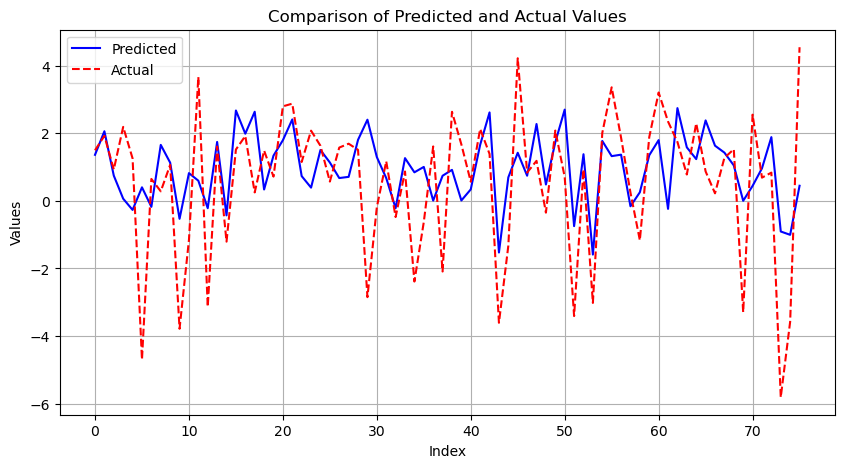

best_lamda: 0.19
Test Normalized Estimation Error: inf
Test NMSE Loss: 0.7293507215262668
Test Correlation: 0.5008633955204331
Test R2 Score: 0.21808866080977707
Objective Function Value: 893.8554852163043


In [10]:
alphas = [0.19]#[0,0.1,0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3, 5, 4,10,15,20,50,100]
k_folds = 2
lambda1, validation_normalized_estimation_errors, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_values = KFoldCV_Vectorized_HCP(X_train, Y_train, alphas, k_folds, intercept= False)

test_normalized_estimation_error, test_nmse_loss, test_correlation, test_R2_score,Y_test_predicted,p_star = TrainTest_Vectorized(X_train, Y_train, X_test, Y_test, lambda1, intercept= False)

#print predicted
print(Y_test_predicted)
print(Y_test)

# Plotting both arrays
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y_test_predicted, label='Predicted', color='blue')  # Plot Y_test_predicted
plt.plot(Y_test, label='Actual', color='red', linestyle='--')  # Plot Y_test with dashed line
plt.title(f"Comparison of Predicted and Actual Values")  # Title of the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
#plt.yscale('log')
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/Vector_Base_Line/HCP Data/Pipeline P0/HCP_ExecutionTime_{formatted_time}.pkl"

print('best_lamda:',lambda1)
print(f"Test Normalized Estimation Error: {test_normalized_estimation_error}")
print(f"Test NMSE Loss: {test_nmse_loss}")
print(f"Test Correlation: {test_correlation}")
print(f"Test R2 Score: {test_R2_score}")
print(f"Objective Function Value: {p_star}")

#print("Validation NMSE Losses: ", validation_nmse_losses)
#print("Validation Correlations: ", validation_correlations)
#print("Validation R2 Scores: ", validation_R2_scores)

with open(pkl_file, "wb") as file:
  dill.dump((p_star,lambda1, validation_normalized_estimation_errors, validation_nmse_losses, validation_correlations, validation_R2_scores, test_normalized_estimation_error, test_nmse_loss, test_correlation, test_R2_score), file)




